[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [20]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_groq

In [21]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [22]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [23]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [24]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-120b",
                 api_key = os.environ.get("GROQ_API_KEY"),
)
llm.invoke(messages)

AIMessage(content='Absolutely! The oceans are home to a surprisingly diverse cast of mammals.\u202fWhile whales often steal the spotlight, there are plenty of other fascinating marine (and semi‑marine) mammals you can explore. Below is a quick guide to the major groups, a few standout species, and some fun facts to spark your curiosity.\n\n---\n\n## 1. **Dolphins & Porpoises (Family Delphinidae & Phocoenidae)**\n| Group | Typical Size | Habitat | Notable Species & Fun Facts |\n|-------|--------------|---------|------------------------------|\n| **Oceanic dolphins** | 2–12\u202fft (0.6–3.5\u202fm) | Open ocean, coastal waters, rivers (e.g., Amazon river dolphin) | **Bottlenose dolphin** – the “classic” dolphin, famous for its intelligence and use of tools. <br>**Orca (Killer whale)** – actually the largest dolphin; apex predator with complex matrilineal societies. |\n| **River dolphins** | 4–8\u202fft (1–2.5\u202fm) | Freshwater rivers & estuaries in South America & Asia | **Amazon rive

We can run our chat model in a simple graph with `MessagesState`.

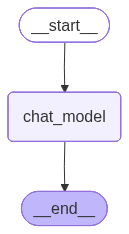

In [25]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

### Ocean Mammals — Beyond Whales

The ocean is home to a surprisingly diverse group of mammals.  While whales (the **cetaceans**) often steal the spotlight, there are several other lineages that have fully adapted to life in salty water. Below is a quick‑reference guide to the main groups, a few standout species, and some fun facts to spark deeper research.

---

## 1. Cetaceans (the “toothed” and “baleen” whales)

| Sub‑group | Representative Species | Key Traits & Fun Facts |
|-----------|------------------------|------------------------|
| **Dolphins** | Bottlenose dolphin (*Tursiops truncatus*), Orca or kill

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

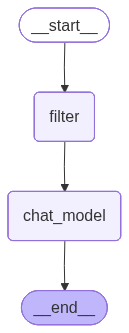

In [27]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

### Dive Deeper into Marine Mammals  
Whales are just the tip of the iceberg (or, more accurately, the tip of the “water‑world”). The oceans are home to a surprisingly diverse group of mammals, each with its own unique adaptations, behaviors, and conservation challenges. Below is a quick guide to the main families you can explore, plus some fun facts and resources to help you get started.

---

## 1. **Dolphins & Porpoises (Family: Delphinidae & Phocoenidae)**
| Species | Where You’ll Find Them | Cool Fact |
|--------|------------------------|-----------|
| **Bottlenose Dolphin** (*Tursiops truncatus*) | Warm and

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

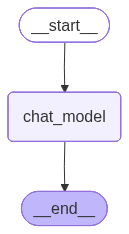

In [29]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [30]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [31]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

### Dive Deeper into Marine Mammals  
Whales are just the tip of the iceberg (or, more accurately, the tip of the “water‑world”). The oceans are home to a surprisingly diverse group of mammals, each with its own unique adaptations, behaviors, and conservation challenges. Below is a quick guide to the main families you can explore, plus some fun facts and resources to help you get started.

---

## 1. **Dolphins & Porpoises

In [32]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

### Dive Deeper into Marine Mammals  
Whales are just the tip of the iceberg (or, more accurately, the tip of the “water‑world”). The oceans are home to a surprisingly diverse group of mammals, each with its own unique adaptations, behaviors, and conservation challenges. Below is a quick guide to the main families you can explore, plus some fun facts and resources to help you get started.

---

## 1. **Dolphins & Porpoises

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

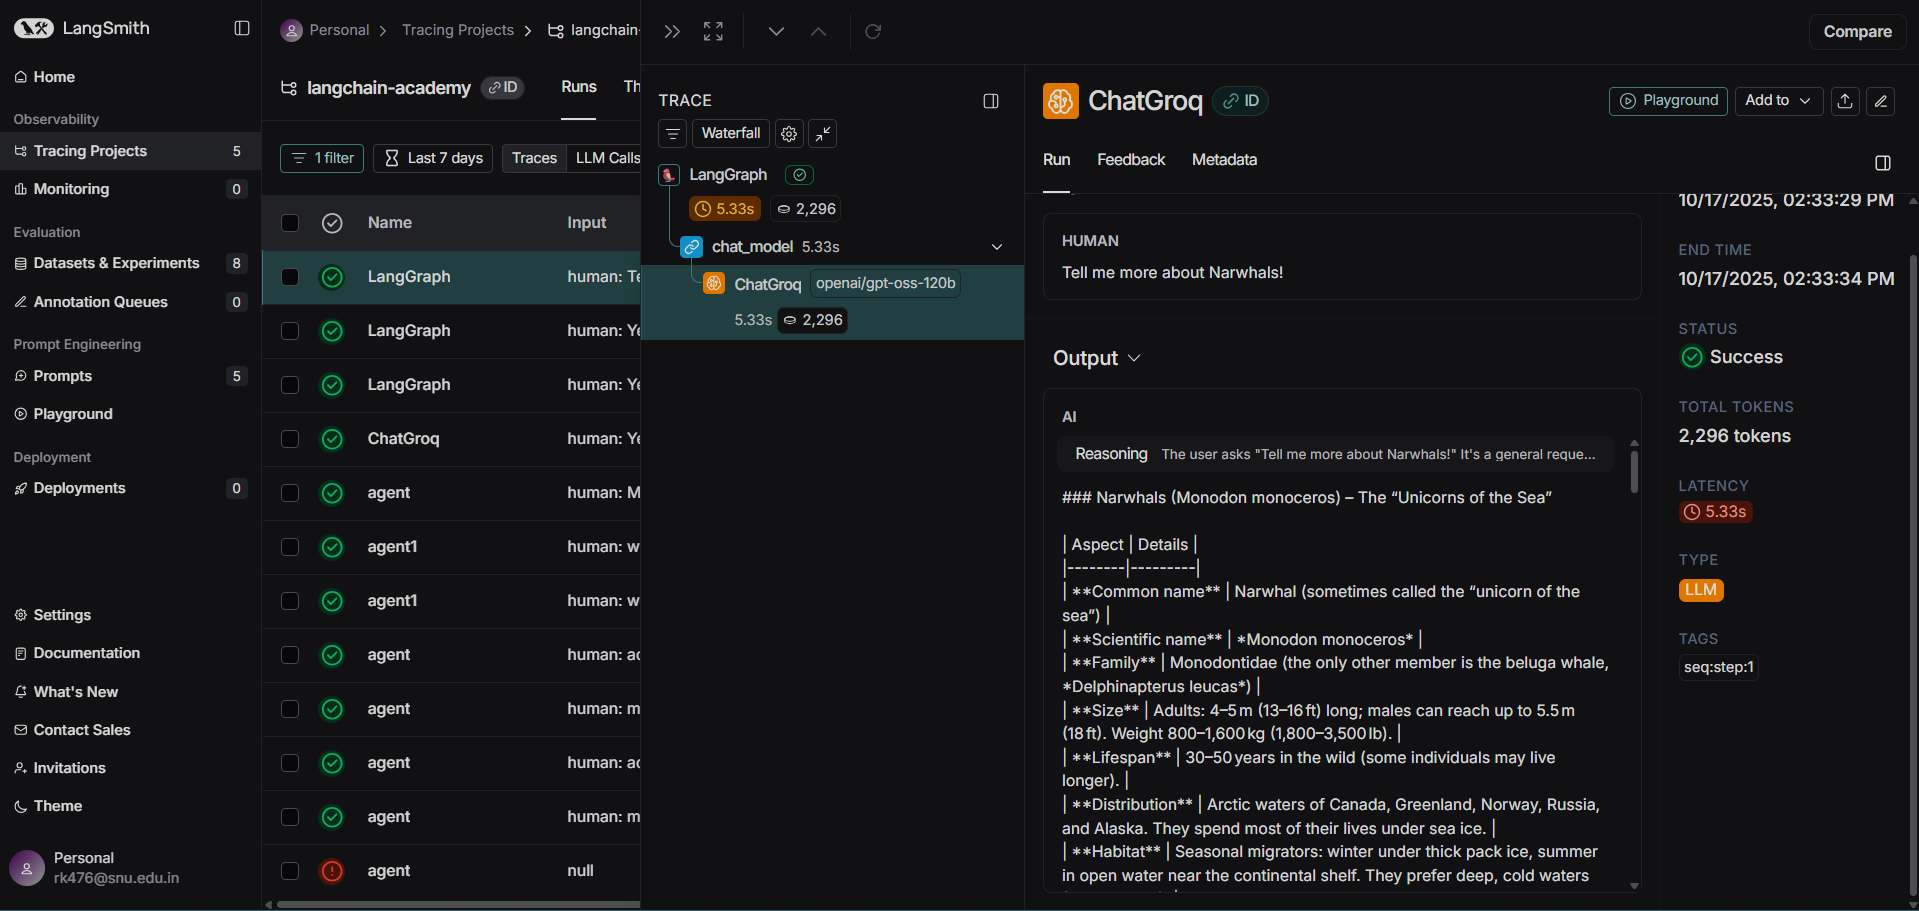

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

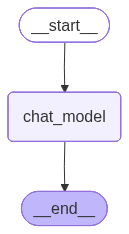

In [33]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model="openai/gpt-oss-120b",
                 api_key = os.environ.get("GROQ_API_KEY"),
            ),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [35]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model="openai/gpt-oss-120b",
                 api_key = os.environ.get("GROQ_API_KEY"),
            ),
            allow_partial=False
        )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2295 > 1024). Running this sequence through the model will result in indexing errors


[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [37]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

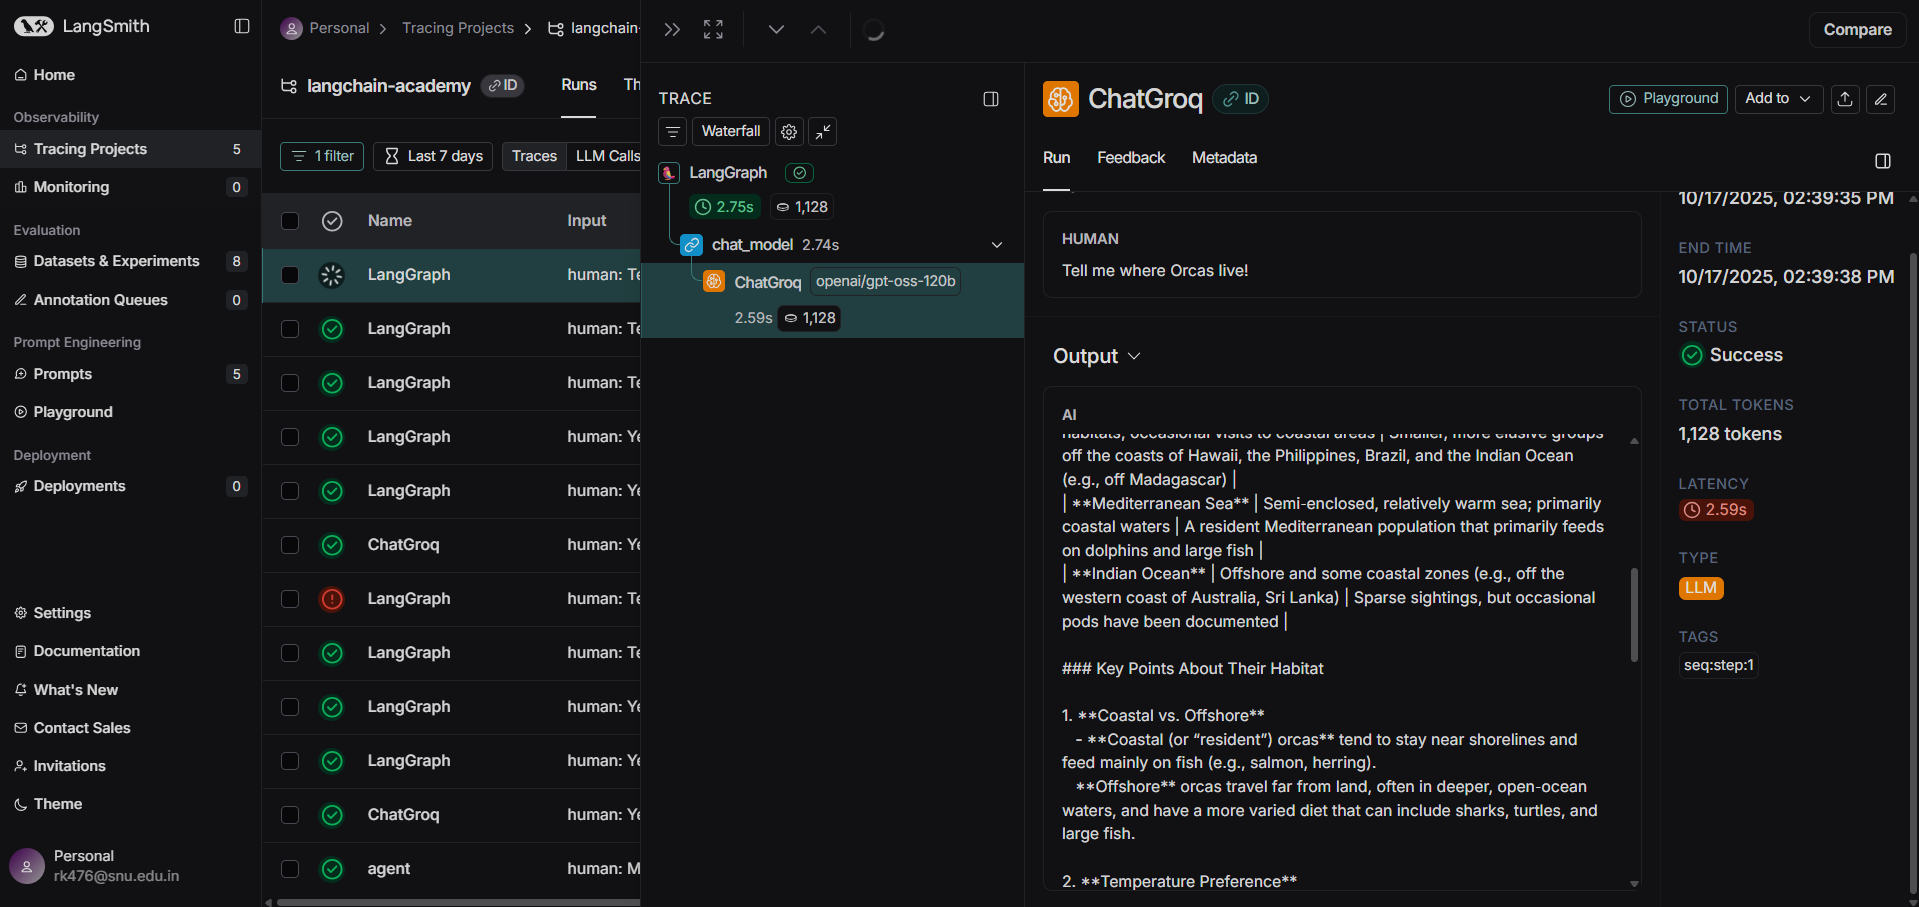

# MY EXAMPLES:

Define a new graph state schema to hold the conversation messages.


In [59]:
from langgraph.graph import MessagesState

# Define the graph state
graph_state = MessagesState

# Print the state definition to confirm
print(graph_state)

<class 'langgraph.graph.message.MessagesState'>


Create a node that uses a reducer to modify the state (e.g., removing old messages).


In [60]:
from langchain_core.messages import RemoveMessage

def reduce_messages_node(state: MessagesState):
    """
    Node to reduce the number of messages in the state by removing all but the last two.

    Args:
        state: The current graph state containing the messages.

    Returns:
        A dictionary with the key "messages" and a list of RemoveMessage objects.
    """
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

Create a node that filters messages before passing them to the language model.


In [61]:
def filter_messages_node(state: MessagesState):
    """
    Node to filter messages and only pass the last message to the language model.

    Args:
        state: The current graph state containing the messages.

    Returns:
        A dictionary with the key "messages" and a list containing the single AIMessage object
        received from the language model call.
    """
    # Access the list of messages from the state
    messages = state["messages"]

    # Filter the messages by selecting only the last message
    filtered_messages = messages[-1:]

    # Invoke the language model with the filtered list of messages
    ai_message = llm.invoke(filtered_messages)

    # Return a dictionary with the key "messages" containing the single AIMessage object
    return {"messages": [ai_message]}

Create a node that trims the messages based on token limits before passing them to the language model.


In [62]:
from langchain_core.messages import trim_messages

def trim_messages_node(state: MessagesState):
    """
    Node to trim messages based on token limits and pass them to the language model.

    Args:
        state: The current graph state containing the messages.

    Returns:
        A dictionary with the key "messages" and a list containing the single AIMessage object
        received from the language model call.
    """
    # Trim the messages based on token limits
    trimmed_messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=llm,  # Use the existing llm object as the token counter
        allow_partial=False,
    )

    # Invoke the language model with the trimmed list of messages
    ai_message = llm.invoke(trimmed_messages)

    # Return a dictionary with the key "messages" containing the single AIMessage object
    return {"messages": [ai_message]}

Construct a LangGraph with the defined nodes for reducer, filtering, and trimming, and define the edges to create a workflow.


Graph for reducing messages:


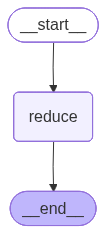


Graph for filtering messages:


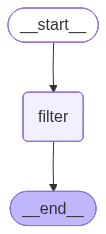


Graph for trimming messages:


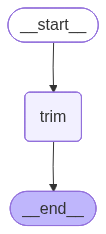

In [63]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from IPython.display import Image, display

# Build graph for reducing messages
builder_reduce = StateGraph(MessagesState)
builder_reduce.add_node("reduce", reduce_messages_node)
builder_reduce.add_edge(START, "reduce")
builder_reduce.add_edge("reduce", END)
graph_reduce = builder_reduce.compile()

print("Graph for reducing messages:")
display(Image(graph_reduce.get_graph().draw_mermaid_png()))

# Build graph for filtering messages
builder_filter = StateGraph(MessagesState)
builder_filter.add_node("filter", filter_messages_node)
builder_filter.add_edge(START, "filter")
builder_filter.add_edge("filter", END)
graph_filter = builder_filter.compile()

print("\nGraph for filtering messages:")
display(Image(graph_filter.get_graph().draw_mermaid_png()))

# Build graph for trimming messages
builder_trim = StateGraph(MessagesState)
builder_trim.add_node("trim", trim_messages_node)
builder_trim.add_edge(START, "trim")
builder_trim.add_edge("trim", END)
graph_trim = builder_trim.compile()

print("\nGraph for trimming messages:")
display(Image(graph_trim.get_graph().draw_mermaid_png()))

Define a new conversation and invoke the graph to demonstrate the process.


In [64]:
# Define a new list of messages
new_messages = [
    HumanMessage(content="Hello there!", name="Alice"),
    AIMessage(content="Hi Alice! How can I help you today?", name="Bot"),
    HumanMessage(content="I have a few questions about the solar system.", name="Alice"),
    AIMessage(content="Great! Ask away.", name="Bot"),
    HumanMessage(content="What is the largest planet in our solar system?", name="Alice"),
]

print("Invoking graph_reduce:")
output_reduce = graph_reduce.invoke({'messages': new_messages})
# for m in output_reduce['messages']:
#     m.pretty_print()

print("\nInvoking graph_filter:")
output_filter = graph_filter.invoke({'messages': new_messages})
# for m in output_filter['messages']:
#     m.pretty_print()

print("\nInvoking graph_trim:")
output_trim = graph_trim.invoke({'messages': new_messages})
# for m in output_trim['messages']:
#     m.pretty_print()

Invoking graph_reduce:

Invoking graph_filter:

Invoking graph_trim:


## Display Results

In [65]:
print("Messages after reduction:")
for m in output_reduce['messages']:
    m.pretty_print()

print("\nMessages after filtering (only the last message is used by the model):")
for m in output_filter['messages']:
    m.pretty_print()

print("\nMessages after trimming (based on token limit):")
for m in output_trim['messages']:
    m.pretty_print()

Messages after reduction:
================================== Ai Message ==================================
Name: Bot

Great! Ask away.
================================ Human Message =================================
Name: Alice

What is the largest planet in our solar system?

Messages after filtering (only the last message is used by the model):
================================ Human Message =================================
Name: Alice

Hello there!
================================== Ai Message ==================================
Name: Bot

Hi Alice! How can I help you today?
================================ Human Message =================================
Name: Alice

I have a few questions about the solar system.
================================== Ai Message ==================================
Name: Bot

Great! Ask away.
================================ Human Message =================================
Name: Alice

What is the largest planet in our solar system?
========================

In Langsmith traces:

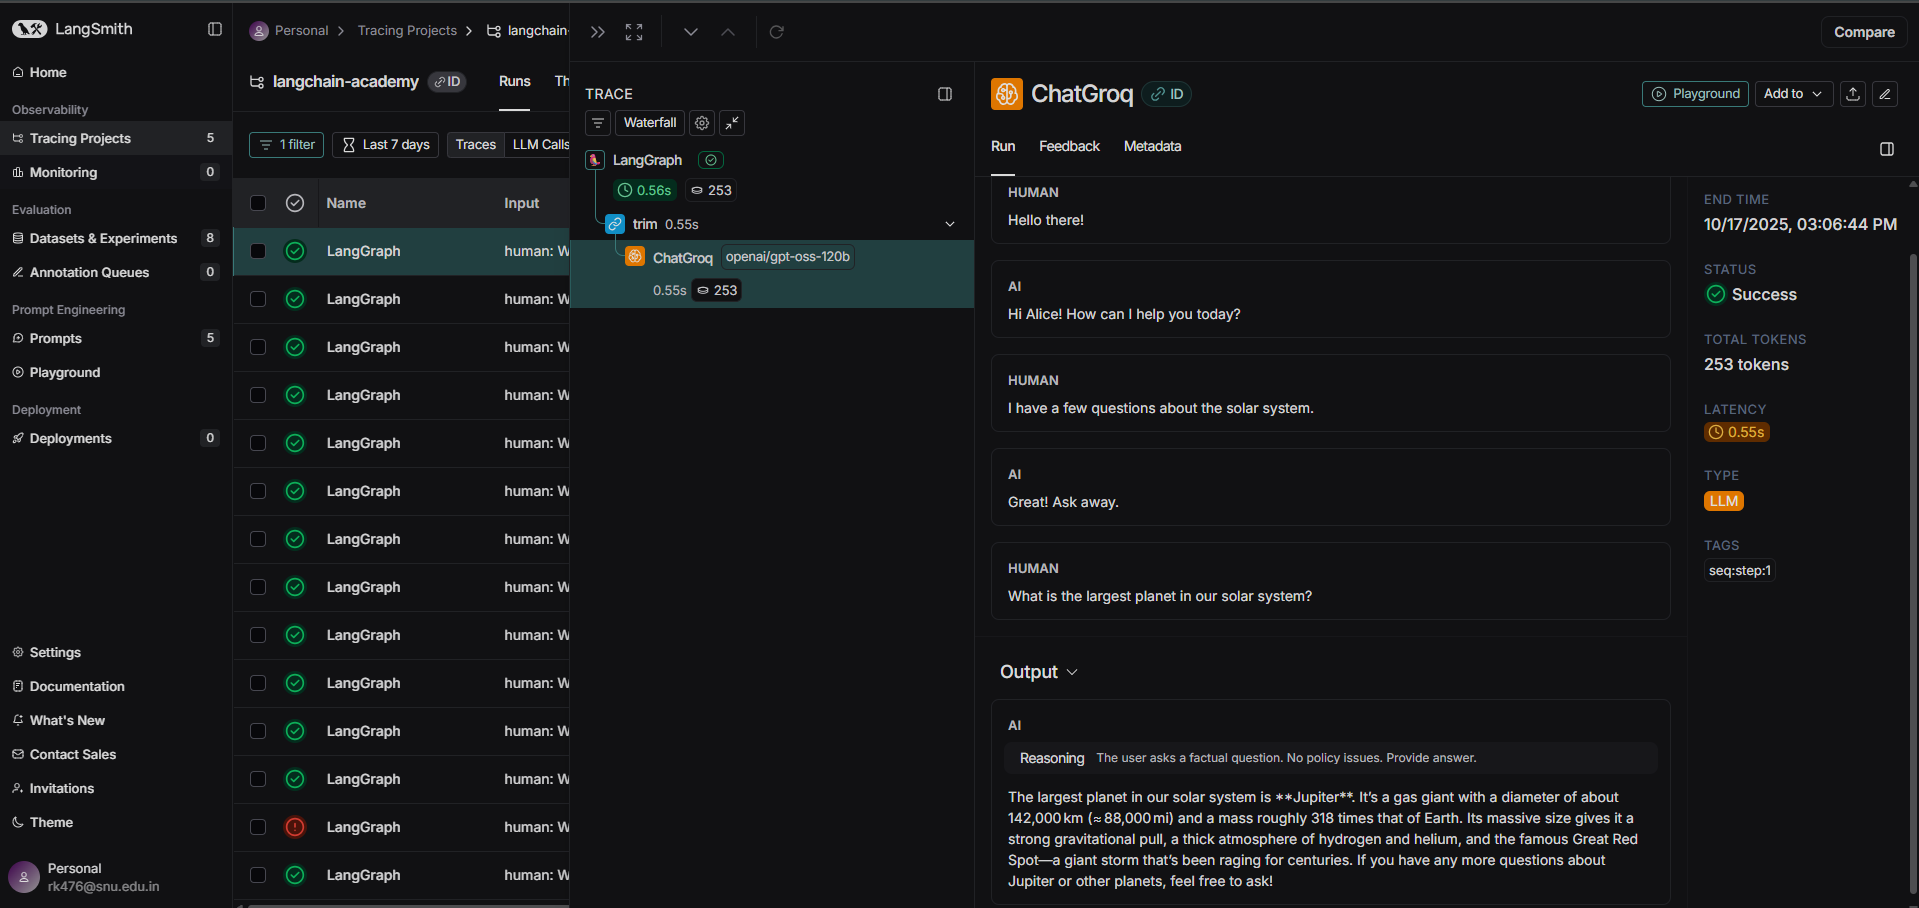